# 8. Proximity Calculations

Phew! We're going to continue building off what we've learned!

**INSTRUCTOR NOTES**:
- Datasets used:
    - "../notebook_data/alco_schools.csv"
    - "../notebook_data/transportation/bart.csv"
    

- Expected time to complete:
    - Lecture + Questions: 20 minutes
    - Challenges: 15 minutes

### Import Packages

In [39]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

In [2]:
# We are getting futurewarning errors about the syntax of CRS definitions, ie "init=epsg:4269" vs "epsg:4269"
# so suppress as these are minor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="section2"></a>
## 8.1 Proximity Analysis Buffers

Proximity analysis is a key part of spatial analysis. It considers what is nearby, in accordance with [Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) which we paraphrase as "*Everything is related but nearby things are more related*."

In practice, distance-based buffer polygons around geospatial features are often used to examine proximal relationships. For example, one may want to consider how many parks are within walking distance of schools in order to identify underserved schools. This could be implemented using the following "recipe":

1. define walking distance, eg 500 meters or 1/3 mile
2. create buffer polygons around park features with a radious of `walking distance`
3. use a spatial join to associate schools with parks
4. count the number of parks with the school buffers.

Buffers can take on different shapes according to your original geometries ("input"). Putting a buffer around these can result in what you see in the second row of the image. The third row would result if we decided to find the entire regions the buffers would cover.

<img src = "https://pro.arcgis.com/en/pro-app/tool-reference/analysis/GUID-267CF0D1-DB92-456F-A8FE-F819981F5467-web.png" height="500" width="500">


 
In this section we will use buffers to enhance our permit data as we ask "*how many BART stations are within walking distance of each Berkeley school location?*"


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

- What is the geometry of our parcel data? 
- What will the buffers look like?
- What do we need to do to the geodataframes before we can spatial join them?


In [3]:
# Write your thoughts here

### Step 1. Prepare the Data

#### Load the school data
First up, we will bring in the Alameda County schools in from `alco_schools.csv` and call it `schools_df`

In [4]:
schools_df = pd.read_csv("../notebook_data/alco_schools.csv")
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public


We'll convert this to a geodataframe

In [5]:
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
schools_gdf.crs = "epsg:4326"

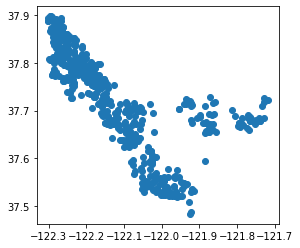

In [6]:
schools_gdf.plot()

In [7]:
schools_gdf.shape

(550, 10)

Now, we can use what we learned in the last section! Let's limit these schools to Berkeley only

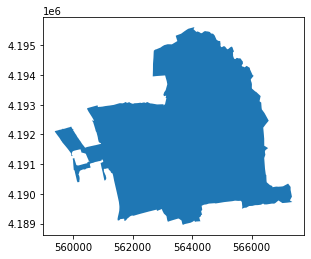

In [8]:
berkeley_outline = gpd.read_file("zip://../qgis_workshop_data/BerkeleyCityLimits.zip")
berkeley_outline.plot()

But before we do that we need to check out CRS!

In [9]:
berkeley_outline.crs == schools_gdf.crs

False

In [10]:
print(berkeley_outline.crs)
print(schools_gdf.crs)

epsg:32610
epsg:4326


Alright, let's just make our crs for our schools the same as our outline.

In [11]:
schools_gdf = schools_gdf.to_crs('epsg:32610')

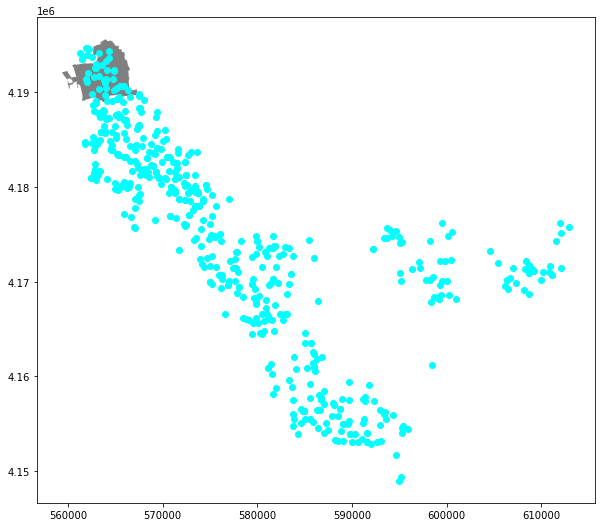

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_outline.plot(color = 'grey', ax=ax)
schools_gdf.plot(color = 'aqua', ax=ax)

And limit it to those that are in Berkeley.

In [13]:
berkeley_schools_gdf = schools_gdf[schools_gdf.intersects(berkeley_outline['geometry'].squeeze())]

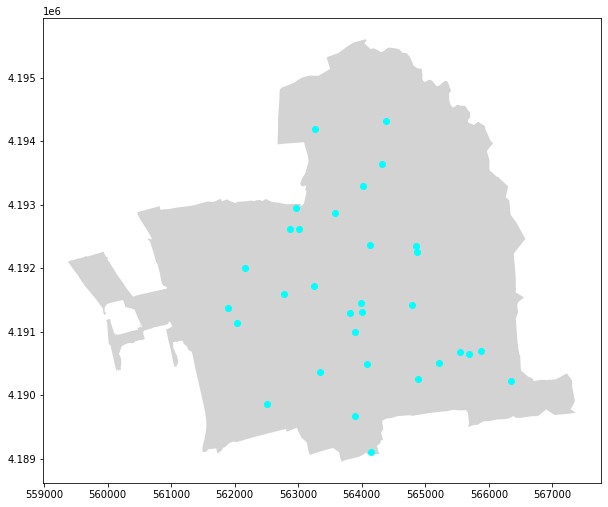

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_outline.plot(color = 'lightgrey', ax=ax)
berkeley_schools_gdf.plot(color = 'aqua', ax=ax)

#### Load the BART Station Data

If we look inside our data folder we see a `bart.csv` file. Let's check it out.

In [15]:
!ls ../qgis_workshop_data/

BerkeleyBikeBlvds.geojson  CaliforniaCounties.shp.xml
BerkeleyCityLimits.zip     CaliforniaCounties.shx
BerkeleyNLCD2011.tif       alco_schools.csv
CaliforniaCounties.dbf     bart.csv
CaliforniaCounties.prj     calcounty_pop2017.csv
CaliforniaCounties.shp     cb_2018_06_place_500k.zip


Since this is a CSV file and not a shapefile or another geographic file format, we will read it in with pandas to a dataframe.

In [16]:
# Read in bart stations
# Read in CSV file
df = pd.read_csv("../notebook_data/transportation/bart.csv")
df.head()

,lon,lat,STATION,OPERATOR,COUNTY
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA
2,-122.270119,37.853207,ASHBY,BART,ALA
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA
4,-122.267120,37.828705,MACARTHUR,BART,ALA


It's a common workflow to get point data in a CSV file. 

Then we convert it to a geodataframe by identifying the columns that contain the point geometry.

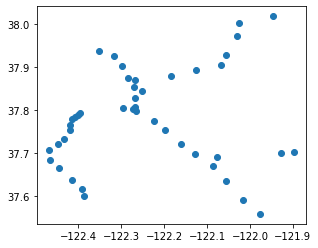

In [17]:
#Convert the DataFrame to a GeoDataFrame. 
bart_gdf = gpd.GeoDataFrame( df, geometry=gpd.points_from_xy(df.lon, df.lat)) 

# and take a look
bart_gdf.plot();

That looks odd... let's switch the lat and longitudes.

In [18]:
# Take a look 
bart_gdf.head()

,lon,lat,STATION,OPERATOR,COUNTY,geometry
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA,POINT (-122.28335 37.87406)
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA,POINT (-122.26825 37.86969)
2,-122.270119,37.853207,ASHBY,BART,ALA,POINT (-122.27012 37.85321)
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA,POINT (-122.25178 37.84451)
4,-122.267120,37.828705,MACARTHUR,BART,ALA,POINT (-122.26712 37.82871)


Since a CSV file doesn't have a CRS we need to define it.

In [19]:
# Check it out
print("Here is our CRS after reading in the CSV file: ", bart_gdf.crs)

# Define the CRS
bart_gdf.crs = 'epsg:4326'

# Check it out
print("Here is our CRS now: ", bart_gdf.crs)


Here is our CRS after reading in the CSV file:  None
Here is our CRS now:  epsg:4326


### Step 2. Define Walking distance

Our goal is to add to the `schools_gdf` geodataframe a column with the number of BART stations within walking distance.

The first step in doing this is to define walking distance. We can read the planning literature for ideas but let's assume for this exercise that it is 500 meters, which is about 1/3 mile.

In [20]:
walking_distance_meters = 500;  # setting walking distance initially to 500 meters

### Step 3. Prepare data for Buffer Analysis

In order to create buffer polygons around our school locations we need to transform our permit geodataframe to a 2D CRS where the units set are meters.  If you recall from our first Geopandas lesson there are a number of these CRSs for California.

Let's use the `California Albers CRS, NAD83 (epsg:3310`) since that can be used for any city in CA.


Now check the CRS of the schools geodataframe.

In [21]:
berkeley_schools_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Create a new permits geodataframe that has the CRS 3310.

In [22]:
schools_3310 = berkeley_schools_gdf.to_crs('epsg:3310')
berkeley_3310 = berkeley_outline.to_crs('epsg:3310')

Now that we've transformed, or reprojected, the permit data, let's plot it. Notice the different coordinate values.

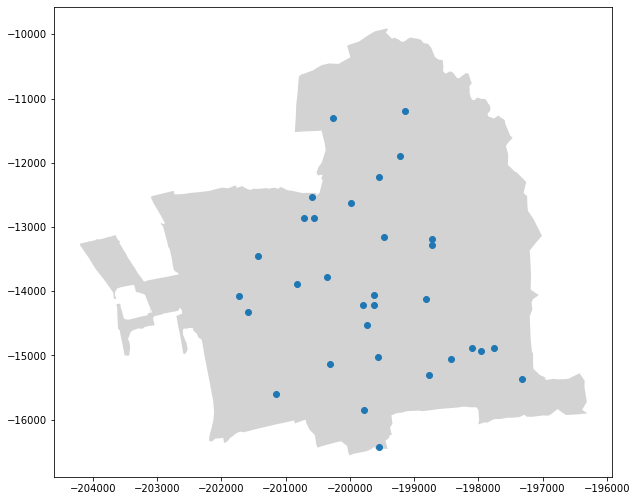

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
berkeley_3310.plot(color = 'lightgrey', ax=ax)
schools_3310.plot(ax=ax) # note the different coordinate values - no longer lat/lon!
plt.show()

Ok, now create a new version of the bart data with the CAL Albers CRS (3310)

In [24]:
# transform the crS
bart_3310 = bart_gdf.to_crs('epsg:3310')

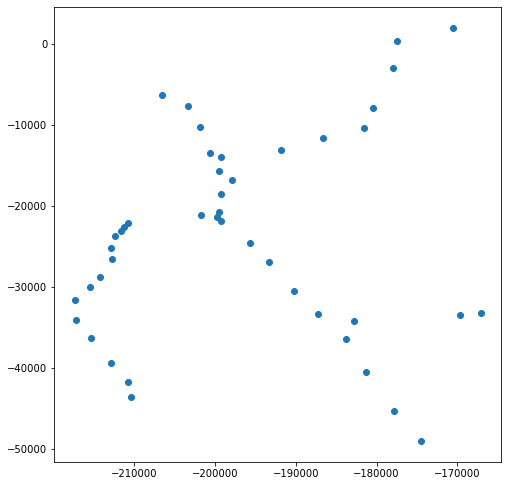

In [25]:
bart_3310.plot(figsize=(8,10)) # note the different coordinate values - no longer lat/lon!
plt.show()

In [26]:
# Take a look at the geodataframe
bart_3310.head()

,lon,lat,STATION,OPERATOR,COUNTY,geometry
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA,POINT (-200562.823 -13404.240)
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA,POINT (-199248.502 -13921.931)
2,-122.270119,37.853207,ASHBY,BART,ALA,POINT (-199456.560 -15749.735)
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA,POINT (-197868.302 -16754.789)
4,-122.267120,37.828705,MACARTHUR,BART,ALA,POINT (-199258.276 -18479.109)


### Step 4.  Create Buffer Polygons

With that we can go on to actually making our buffers around the BART Stations that have the `walking distance` as the radius. We do this with the Geopandas geodataframe `.buffer()` method.

In [27]:
# Make sure
bart_3310 = bart_gdf.to_crs('epsg:3310')

bart_buf = bart_3310.buffer(distance=walking_distance_meters)

Now let's map the output.

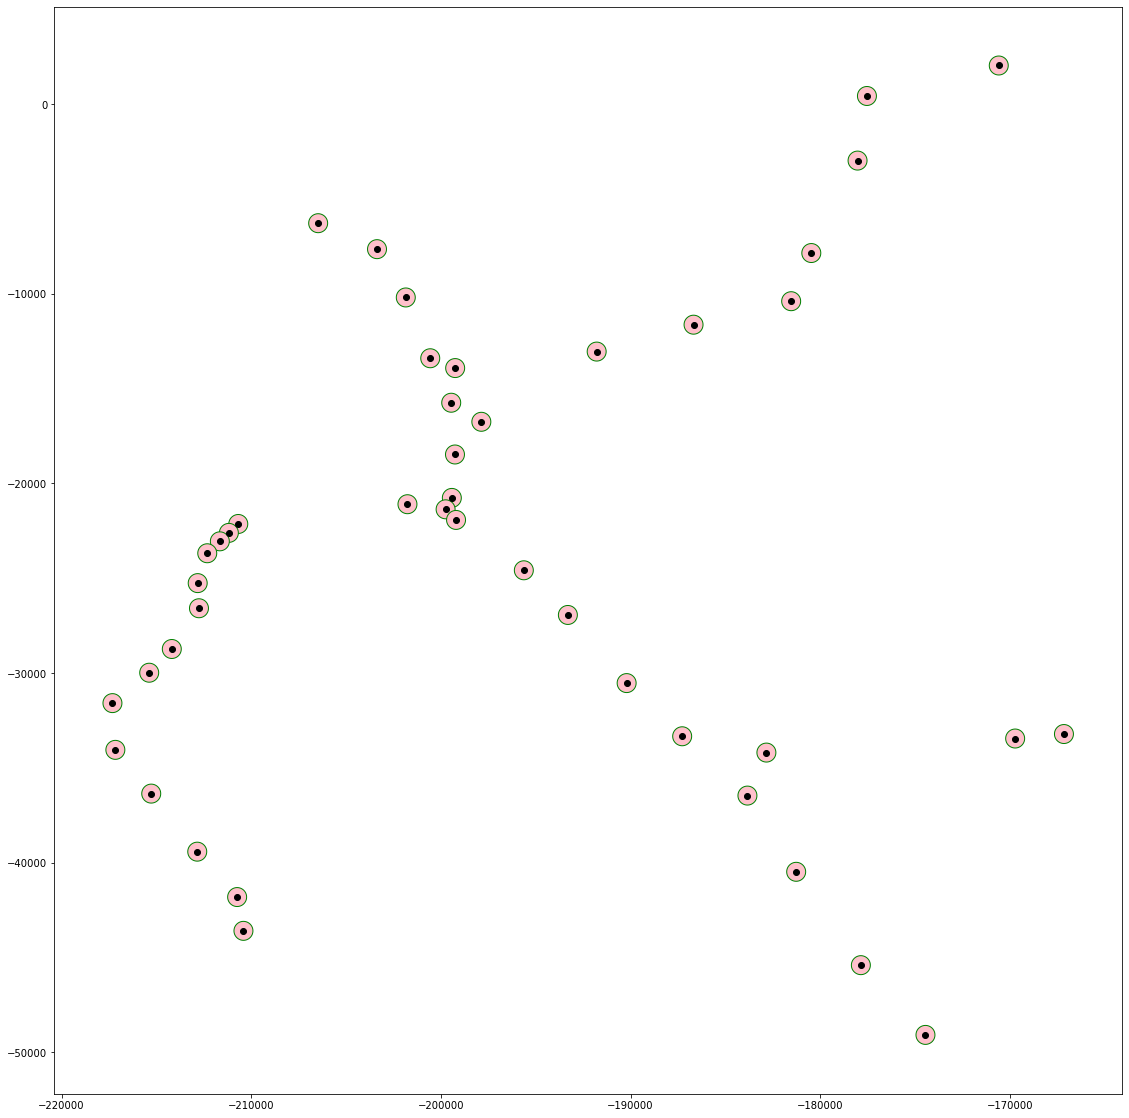

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
bart_buf.plot(ax=ax, color="pink", edgecolor="green")
bart_3310.plot(ax=ax, color='black')
plt.show()

Let's add the permit points to the map

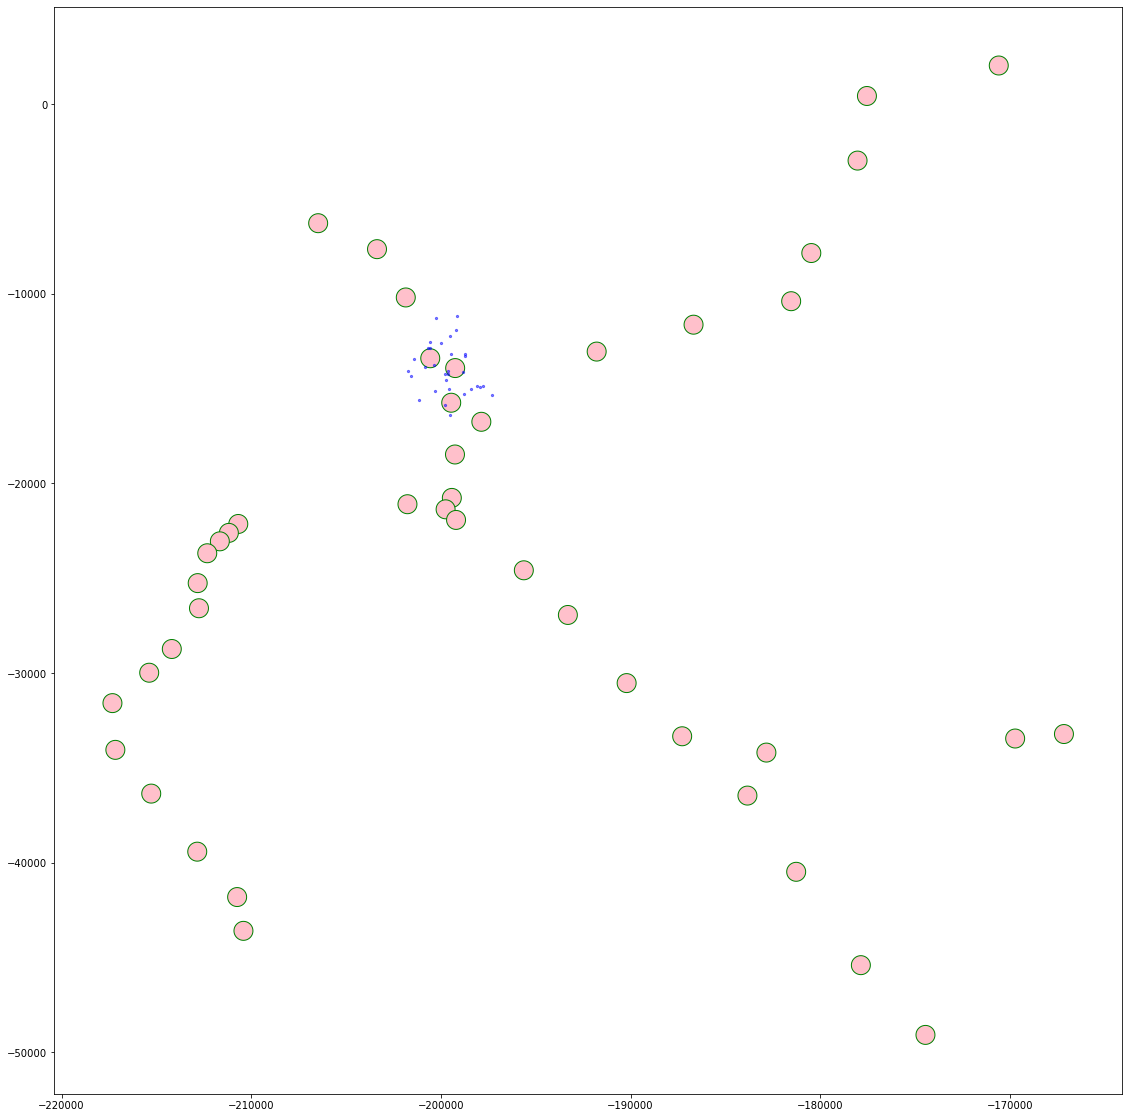

In [29]:
# Map it
fig, ax = plt.subplots(figsize = (20,20)) 

# Display the buffer output
bart_buf.plot(ax=ax,color="pink", edgecolor="green")

# Overlay the permit points
schools_3310.plot(ax=ax, color="blue", alpha=0.5, markersize=5)

plt.show()

You can see from the map above that each BART station now has a buffer polygon.

You also get a sense that some but not all permit locations are near Bart stations.

Let's take a quick look at the data in the buffer output `bart_buf`.

In [30]:
bart_buf.head()

0    POLYGON ((-200062.823 -13404.240, -200065.231 ...
1    POLYGON ((-198748.502 -13921.931, -198750.910 ...
2    POLYGON ((-198956.560 -15749.735, -198958.968 ...
3    POLYGON ((-197368.302 -16754.789, -197370.710 ...
4    POLYGON ((-198758.276 -18479.109, -198760.684 ...
dtype: geometry

What type of data is that?

In [31]:
type(bart_buf)

geopandas.geoseries.GeoSeries

The output of the `buffer` operation is a Geopandas `GeoSeries` NOT a geodataframe. Before we can proceed we need to create a geodataframe.

We can create a geodataframe by combining a few key columns from the permit data with the buffer geometry.

In [32]:
# Create a permit_buf geodataframe
bart_buf_gdf = gpd.GeoDataFrame(data=bart_3310[['STATION']],
                                  geometry=bart_buf)

In [33]:
# Take a look at our permit buffer geodataframe
bart_buf_gdf.head()

,STATION,geometry
0,NORTH BERKELEY,"POLYGON ((-200062.823 -13404.240, -200065.231 ..."
1,DOWNTOWN BERKELEY,"POLYGON ((-198748.502 -13921.931, -198750.910 ..."
2,ASHBY,"POLYGON ((-198956.560 -15749.735, -198958.968 ..."
3,ROCKRIDGE,"POLYGON ((-197368.302 -16754.789, -197370.710 ..."
4,MACARTHUR,"POLYGON ((-198758.276 -18479.109, -198760.684 ..."


Nice work! We now have a geodataframe with all of our bart 500m buffer polygons and our permit geodataframe. And we can zoom into see which schools have a bart station within walking distance.

In [34]:
# We'll limit by the total bounds of our berkeley outline
minx, miny, maxx, maxy = berkeley_3310.geometry.total_bounds

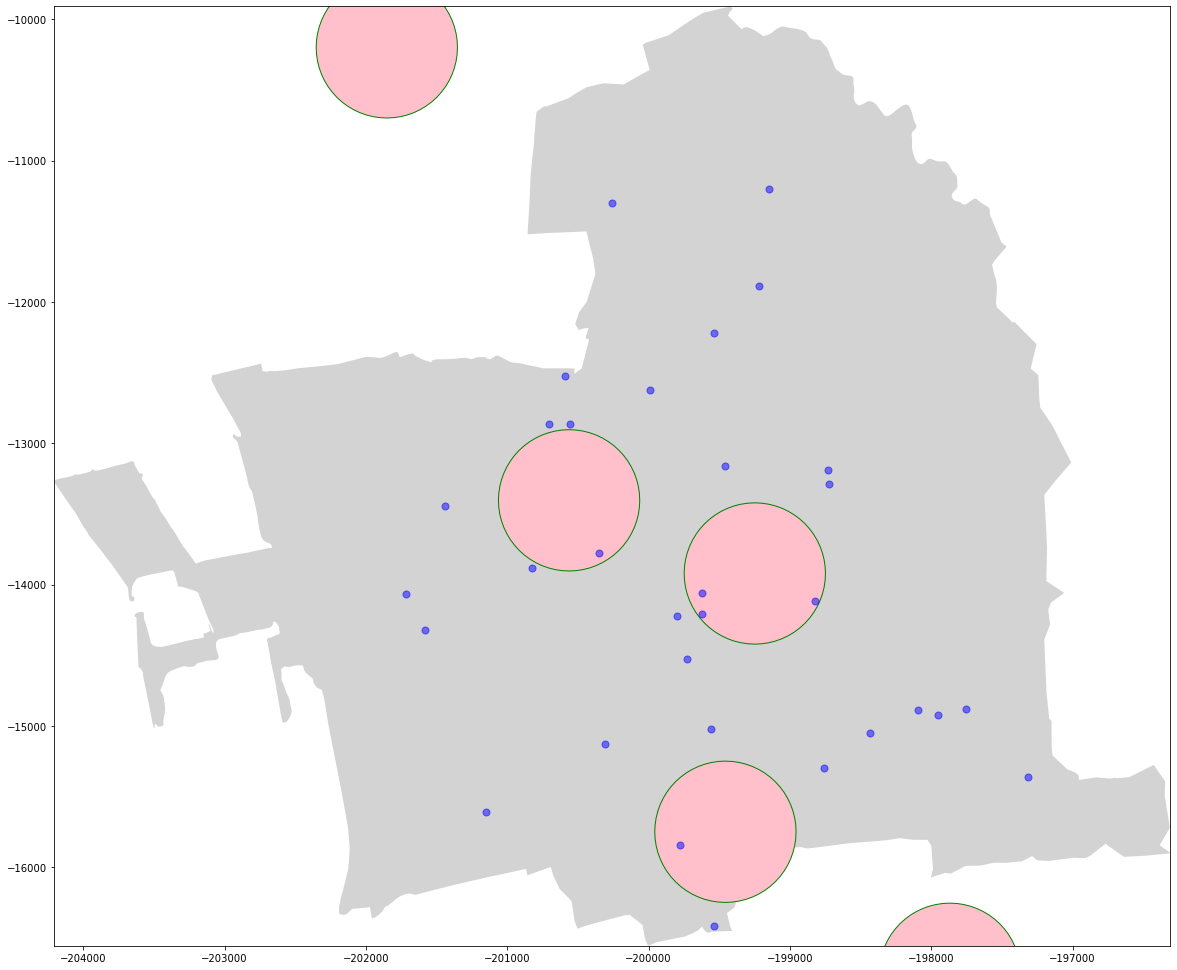

In [35]:
# Map it
fig, ax = plt.subplots(figsize = (20,20)) 

# Berkeley outline 
berkeley_3310.plot(color = 'lightgrey', ax=ax)

# Display the buffer output
bart_buf.plot(ax=ax,color="pink", edgecolor="green")

# Overlay the permit points
schools_3310.plot(ax=ax, color="blue", alpha=0.5, markersize=50)

# Limit by Berkeley
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.show()

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>
How would you go from a buffer polygon geodataframe back to a point geodataframe?

In [36]:
# Write your thoughts

**In the next notebook we'll go a step further to actually be able to quantify this instead of just looking at a map and counting ourselves**

In order to be able to identify those schools we first want to create a new variable called `bart_count`. Since each row is for one Bart station, we're going to set our variable to 1 for every entry.  

> This type of variable is often called a `dichotomous variable`, `binary variable` or `dummy_variable`.

In [37]:
bart_buf_gdf['bart_count'] = 1
bart_buf_gdf.head(5)

,STATION,geometry,bart_count
0,NORTH BERKELEY,"POLYGON ((-200062.823 -13404.240, -200065.231 ...",1
1,DOWNTOWN BERKELEY,"POLYGON ((-198748.502 -13921.931, -198750.910 ...",1
2,ASHBY,"POLYGON ((-198956.560 -15749.735, -198958.968 ...",1
3,ROCKRIDGE,"POLYGON ((-197368.302 -16754.789, -197370.710 ...",1
4,MACARTHUR,"POLYGON ((-198758.276 -18479.109, -198760.684 ...",1


Let's save out our datasets so we can use it in the next notebook.

In [38]:
bart_buf_gdf.to_file("../outdata/bart_buffers.json", driver="GeoJSON")
schools_3310.to_file("../outdata/berkeley_schools.json", driver="GeoJSON")

## 8.2 Challenge
Do the same analysis, but this time let's try to see how many bike paths are within walking distance to schools.
1. Pull in `BerkeleyBikeBlvds.geojson` which is in the folder `notebook_data/transportation`
2. Compare Coordinate Reference Systems. If it's not the same as schools, convert it.
3. Create buffers around bike boulevards (note what shape it takes! Try plotting it)
4. Zoom in on your plot and see how many schools are within walking distance

In [40]:
# Your code here

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>